### TFIDF -- MODELLING USING DECISION TREES

In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
#import seaborn as sns
import sklearn
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import bz2
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

In [2]:
infile=bz2.BZ2File("train_tfidf_2","rb")
train_tfidf_2=pickle.load(infile)
infile.close()

In [3]:
infile=bz2.BZ2File("train_tfidf_1","rb")
train_tfidf_1=pickle.load(infile)
infile.close()

In [4]:
train_tfidf=pd.concat((train_tfidf_1,train_tfidf_2),axis=0)

In [5]:
infile=bz2.BZ2File("ytrain","rb")
ytrain=pickle.load(infile)
infile.close()

In [6]:
infile=bz2.BZ2File("ytest","rb")
ytest=pickle.load(infile)
infile.close()

In [7]:
infile=bz2.BZ2File("test_tfidf","rb")
test_tfidf=pickle.load(infile)
infile.close()

In [8]:
test_tfidf.shape

(21850, 14041)

In [9]:
gcv_max_depth=10
gcv_min_samples_split=10

In [10]:
tree=DecisionTreeClassifier(max_depth=gcv_max_depth,min_samples_split=gcv_min_samples_split,class_weight="balanced")

In [11]:
tree.fit(train_tfidf,ytrain)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [12]:
ytest_predictproba=tree.predict_proba(test_tfidf)[:,1]
ytest_predict=tree.predict(test_tfidf)

In [13]:
ytrain_predictproba=tree.predict_proba(train_tfidf)[:,1]
ytrain_predict=tree.predict(train_tfidf)


In [14]:
from sklearn.metrics import roc_auc_score

In [15]:
train_auc=roc_auc_score(ytrain,ytrain_predictproba)
train_auc

0.733473514787962

In [16]:
test_auc=roc_auc_score(ytest,ytest_predictproba)
test_auc

0.6462290926954681

##### CONFUSION_MATRIX

In [17]:
from sklearn.metrics import confusion_matrix

In [18]:
confusion_matrix(ytrain,ytrain_predict)

array([[ 7863,  2724],
       [23662, 35669]])

In [19]:
test_confusion=pd.DataFrame(confusion_matrix(ytest,ytest_predict),index=["actual_neg","actual_pos"],columns=["pred_neg","pred_pos"])
test_confusion

,pred_neg,pred_pos
actual_neg,2112,1196
actual_pos,7725,10817


In [20]:
train_confusion=pd.DataFrame(confusion_matrix(ytrain,ytrain_predict),index=["actual_neg","actual_pos"],columns=["pred_neg","pred_pos"])
train_confusion

,pred_neg,pred_pos
actual_neg,7863,2724
actual_pos,23662,35669


##### ROC_CURVE

In [21]:
from sklearn.metrics import roc_curve
fpr_train,tpr_train,thersholds_train=roc_curve(ytrain,ytrain_predictproba)
fpr_test,tpr_test,thersholds_test=roc_curve(ytest,ytest_predictproba)

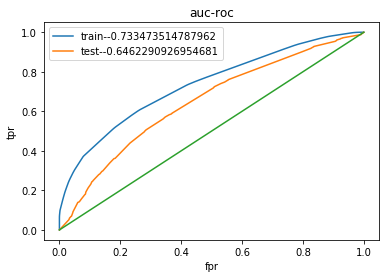

In [22]:
plt.plot(fpr_train,tpr_train,label="train--"+str(train_auc))
plt.plot(fpr_test,tpr_test,label="test--"+str(test_auc))
plt.plot([0.0,0.1,0.5,1.0],[0.0,0.1,0.5,1.0])
plt.legend()
plt.title("auc-roc")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()
plt.close()

### with  FALSE POSITIVES

In [23]:
a=set(test_tfidf[ytest==1 ].index) 
b=set(test_tfidf[ytest_predict==0 ].index)

In [24]:
len(a),len(b),len(test_tfidf)

(18542, 9837, 21850)

In [25]:
fp_index=set.intersection(a,b)
len(fp_index)

7725

In [26]:
infile=bz2.BZ2File("Xtest","rb")
fp_xtes=pickle.load(infile)
infile.close()

In [27]:
fp_xtest=pd.DataFrame(np.array(fp_xtes),columns=fp_xtes.columns).loc[sorted(fp_index)]

In [28]:
len(fp_xtest)

7725

In [29]:
outfile=bz2.BZ2File("fp_xtest","wb")
pickle.dump(fp_xtest,outfile)
outfile.close()


In [30]:
fp_xtest["essay"]

0        my students wonderful group first second grade...
1        my 3rd grade classroom allows students achieve...
2        the school title one inner city school 70 stud...
12       my students energetic motivated curious learn ...
14       i blessed faculty sponsor high school boys soc...
                               ...                        
21835    our school nurturing environment work instill ...
21841    we start day student sharing reading i amazed ...
21842    i work students kindergarten fifth grade every...
21848    my student beyond special kids although may st...
21849    my students curious fifth sixth graders love h...
Name: essay, Length: 7725, dtype: object

### TFIDF--Modelling  after removing features with zero importance

In [46]:
features_index=np.where([tree.feature_importances_!=0])[1]

In [47]:
features=set(train_tfidf.columns[features_index])


In [33]:
len(features)

215

In [34]:
test=test_tfidf[features]
test.shape

(21850, 218)

In [35]:
train=train_tfidf[features]
train.shape

(69918, 218)

In [36]:
outfile=bz2.BZ2File("test","wb")
pickle.dump(test,outfile)
outfile.close()


In [37]:
outfile=bz2.BZ2File("train","wb")
pickle.dump(train,outfile)
outfile.close()


In [38]:
sgd=LogisticRegression(class_weight="balanced",max_iter=1000)
gcv=GridSearchCV(estimator=sgd,param_grid={'C':[0.0001,0.001,0.01,0.1,1,10,100,1000]},scoring="roc_auc",n_jobs=-1,return_train_score=True)

In [39]:
ytrain=ytrain.reshape(69918,)

In [40]:
gcv.fit(train,ytrain)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

In [41]:
gcv.cv_results_

{'mean_fit_time': array([ 1.06100898,  1.59942489,  2.6118432 ,  5.66592669, 15.24622474,
        18.67900715, 23.10720801, 24.5346241 ]),
 'std_fit_time': array([0.18266411, 0.13315812, 0.34780244, 1.21422408, 2.97774242,
        4.60586238, 4.8096341 , 3.76668089]),
 'mean_score_time': array([0.05088234, 0.05163641, 0.0470046 , 0.04083824, 0.03812289,
        0.02558293, 0.02135029, 0.02221737]),
 'std_score_time': array([0.00898178, 0.00483375, 0.01133191, 0.0116706 , 0.01303192,
        0.00502321, 0.00371509, 0.00546066]),
 'param_C': masked_array(data=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.0001},
  {'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10},
  {'C': 100},
  {'C': 1000}],
 'split0_test_score': array([0.61888201, 0.62625566, 0.66920453, 0.6964595 , 0.6997694 ,
        0.70163418, 0.70189635, 0.70191513]),

In [48]:
sgd=LogisticRegression(C=1000,max_iter=1000)

In [49]:
sgd.fit(train,ytrain)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [50]:
train_pred=sgd.predict(train)

In [51]:
train_prob=sgd.predict_proba(train)[:,1]
train_prob

array([0.56453027, 0.92554306, 0.95592197, ..., 0.77270093, 0.95225162,
       0.8756567 ])

In [52]:
auc_train=roc_auc_score(ytrain,train_prob)
auc_train

0.7042431385824872

In [53]:
test.columns

Index(['letters', 'ball', 'make', 'treat', 'physical', 'chairs', 'makes',
       'world', 'actively', 'opportunities',
       ...
       'also', 'words', 'used', 'needed', 'these', 'handicap', 'chair',
       'hardest', 'supplies', 'replace'],
      dtype='object', length=218)

In [54]:
train.columns

Index(['letters', 'ball', 'make', 'treat', 'physical', 'chairs', 'makes',
       'world', 'actively', 'opportunities',
       ...
       'also', 'words', 'used', 'needed', 'these', 'handicap', 'chair',
       'hardest', 'supplies', 'replace'],
      dtype='object', length=218)

In [55]:
test_pred=sgd.predict(test)

In [56]:
test_prob=sgd.predict_proba(test)[:,1]
test_prob

array([0.84884261, 0.84528871, 0.89767511, ..., 0.89799255, 0.6971863 ,
       0.66090285])

In [57]:
auc_test=roc_auc_score(ytest,test_prob)
auc_test

0.7061303159975256

In [58]:
from sklearn.metrics import roc_curve
fpr_train,tpr_train,thersholds_train=roc_curve(ytrain,train_prob)
fpr_test,tpr_test,thersholds_test=roc_curve(ytest,test_prob)

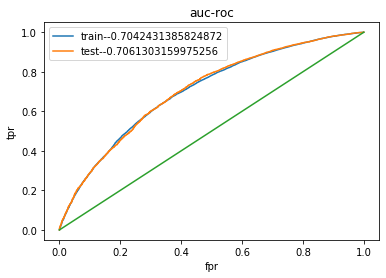

In [59]:
plt.plot(fpr_train,tpr_train,label="train--"+str(auc_train))
plt.plot(fpr_test,tpr_test,label="test--"+str(auc_test))
plt.plot([0.0,0.1,0.5,1.0],[0.0,0.1,0.5,1.0])
plt.legend()
plt.title("auc-roc")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()
plt.close()

In [60]:
train_confusion=pd.DataFrame(confusion_matrix(ytrain,train_pred),index=["actual_neg","actual_pos"],columns=["pred_neg","pred_pos"])
train_confusion

,pred_neg,pred_pos
actual_neg,214,10373
actual_pos,172,59159


In [61]:
test_confusion=pd.DataFrame(confusion_matrix(ytest,test_pred),index=["actual_neg","actual_pos"],columns=["pred_neg","pred_pos"])
test_confusion

,pred_neg,pred_pos
actual_neg,74,3234
actual_pos,49,18493
